## Часть первая: перенос стиля при помощи pix2pix
В этом задании мы будем реализовывать перенос стиля на спаренных данных (paired data). Из стандартных датасетов я выбрал самый маленький -- давайте реализуем перенос стиля из масок сегментации в “настоящие фотографии” для конкретного случая фасадов домов:

Датасет можно скачать здесь (и во многих других местах, должно быть ~29 мегабайт).
В первой части подразумевается реализация pix2pix архитектуры, т.е. генератора и дискриминатора, которые получают на вход условие в виде изображения исходного стиля (подробнее см. лекцию и собственно Isola et al., 2016):


Для первого задания использовала код, взятый из туториала по TF:
https://www.tensorflow.org/tutorials/generative/pix2pix

In [1]:
import tensorflow as tf

import os
import pathlib
import time
import datetime

from matplotlib import pyplot as plt
from IPython import display
import numpy as np
import pandas as pd
import os, math, sys
import time, datetime
import glob, itertools
import argparse, random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
from torch.autograd import Variable
from torchvision.models import vgg19
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import save_image, make_grid

import plotly
from scipy import signal
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split

random.seed(42)
import warnings
warnings.filterwarnings("ignore")

### Предобработка данных

Загрузим датасет

In [35]:
dataset_name = "facades"

In [36]:
_URL = f'http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/{dataset_name}.tar.gz'

path_to_zip = tf.keras.utils.get_file(
    fname=f"{dataset_name}.tar.gz",
    origin=_URL,
    extract=True)

path_to_zip  = pathlib.Path(path_to_zip)

PATH = path_to_zip.parent/dataset_name

In [37]:
list(PATH.parent.iterdir())

[PosixPath('/root/.keras/datasets/facades.tar.gz'),
 PosixPath('/root/.keras/datasets/facades')]

Каждая картинка имеет размер `256 x 512` и состорит из двух изображений `256 x 256`:

In [38]:
sample_image = tf.io.read_file(str(PATH / 'train/1.jpg'))
sample_image = tf.io.decode_jpeg(sample_image)
print(sample_image.shape)

(256, 512, 3)


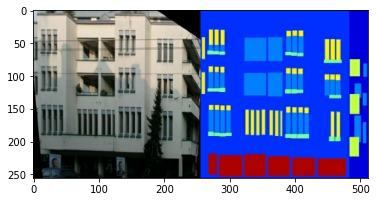

In [39]:
plt.figure()
plt.imshow(sample_image)

Разделяем картинки, делаем из них тензоры:

In [40]:
def load(image_file):
  # Read and decode an image file to a uint8 tensor
  image = tf.io.read_file(image_file)
  image = tf.io.decode_jpeg(image)

  # Split each image tensor into two tensors:
  # - one with a real building facade image
  # - one with an architecture label image 
  w = tf.shape(image)[1]
  w = w // 2
  input_image = image[:, w:, :]
  real_image = image[:, :w, :]

  # Convert both images to float32 tensors
  input_image = tf.cast(input_image, tf.float32)
  real_image = tf.cast(real_image, tf.float32)

  return input_image, real_image

Изобразим реальное изображение и схему:

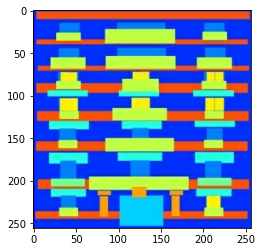

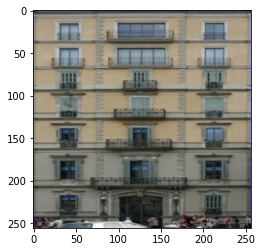

In [41]:
inp, re = load(str(PATH / 'train/99.jpg'))
# Casting to int for matplotlib to display the images
plt.figure()
plt.imshow(inp / 255.0)
plt.figure()
plt.imshow(re / 255.0)

Добавим функции по предобработке изображений:

In [42]:
# The facade training set consist of 400 images
BUFFER_SIZE = 400
# The batch size of 1 produced better results for the U-Net in the original pix2pix experiment
BATCH_SIZE = 1
# Each image is 256x256 in size
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [43]:
def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image

In [44]:
def random_crop(input_image, real_image):
  stacked_image = tf.stack([input_image, real_image], axis=0)
  cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image[0], cropped_image[1]

In [45]:
# Normalizing the images to [-1, 1]
def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1

  return input_image, real_image

In [46]:
@tf.function()
def random_jitter(input_image, real_image):
  # Resizing to 286x286
  input_image, real_image = resize(input_image, real_image, 286, 286)

  # Random cropping back to 256x256
  input_image, real_image = random_crop(input_image, real_image)

  if tf.random.uniform(()) > 0.5:
    # Random mirroring
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)

  return input_image, real_image

In [47]:
def load_image_train(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = random_jitter(input_image, real_image)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [48]:
def load_image_test(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

Строим пайплайн:

In [49]:
train_dataset = tf.data.Dataset.list_files(str(PATH / 'train/*.jpg'))
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [50]:
try:
  test_dataset = tf.data.Dataset.list_files(str(PATH / 'test/*.jpg'))
except tf.errors.InvalidArgumentError:
  test_dataset = tf.data.Dataset.list_files(str(PATH / 'val/*.jpg'))
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

### Строим генератор.
Генератор - модифицированный U-Net. U-Net состоит из энкодера и декодера. 

- Каждый блок в энкодере: Convolution -> Batch normalization -> Leaky ReLU
- Каждый блок в декодере: Transposed convolution -> Batch normalization -> Dropout (applied to the first 3 blocks) -> ReLU


In [51]:
OUTPUT_CHANNELS = 3

In [52]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [53]:
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(inp, 0))
print (down_result.shape)

(1, 128, 128, 3)


In [54]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [55]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 256, 256, 3)


In [56]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[256, 256, 3])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    downsample(128, 4),  # (batch_size, 64, 64, 128)
    downsample(256, 4),  # (batch_size, 32, 32, 256)
    downsample(512, 4),  # (batch_size, 16, 16, 512)
    downsample(512, 4),  # (batch_size, 8, 8, 512)
    downsample(512, 4),  # (batch_size, 4, 4, 512)
    downsample(512, 4),  # (batch_size, 2, 2, 512)
    downsample(512, 4),  # (batch_size, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample(512, 4),  # (batch_size, 16, 16, 1024)
    upsample(256, 4),  # (batch_size, 32, 32, 512)
    upsample(128, 4),  # (batch_size, 64, 64, 256)
    upsample(64, 4),  # (batch_size, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

### Определим лосс генератора

In [57]:
LAMBDA = 100

In [58]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [59]:
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # Mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

### Определим дискриминатор

In [60]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
  down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
  down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

### Определим лосс дискриминатора

In [61]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

### Определим оптимизаторы и сохранение модели

In [62]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [63]:
generator = Generator()
discriminator = Discriminator()

In [64]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

### Рисуем изображения

In [65]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15, 15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # Getting the pixel values in the [0, 1] range to plot.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

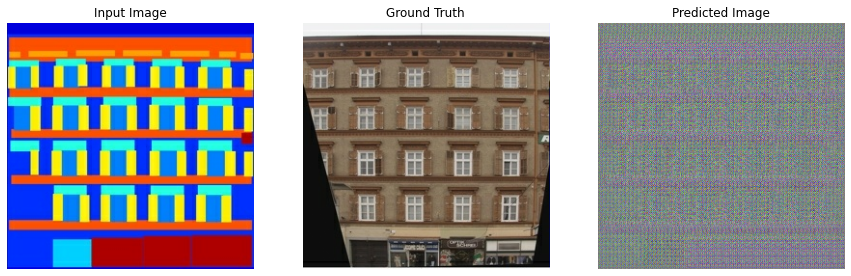

In [66]:
for example_input, example_target in test_dataset.take(1):
  generate_images(generator, example_input, example_target)

### Обучение

In [67]:
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [68]:
@tf.function
def train_step(input_image, target, step):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
    tf.summary.scalar('disc_loss', disc_loss, step=step//1000)

In [69]:
def fit(train_ds, test_ds, steps):
  example_input, example_target = next(iter(test_ds.take(1)))
  start = time.time()

  for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
    if (step) % 1000 == 0:
      display.clear_output(wait=True)

      if step != 0:
        print(f'Time taken for 1000 steps: {time.time()-start:.2f} sec\n')

      start = time.time()

      generate_images(generator, example_input, example_target)
      print(f"Step: {step//1000}k")

    train_step(input_image, target, step)

    # Training step
    if (step+1) % 10 == 0:
      print('.', end='', flush=True)


    # Save (checkpoint) the model every 5k steps
    if (step + 1) % 5000 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)

Time taken for 1000 steps: 55.77 sec



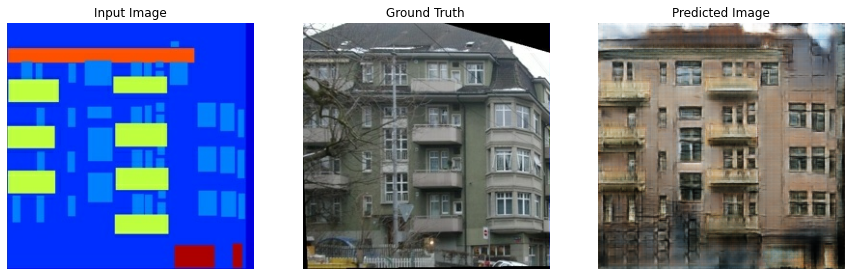

Step: 39k
....................................................................................................

In [70]:
fit(train_dataset, test_dataset, steps=40000)

In [71]:
!ls {checkpoint_dir}

checkpoint		    ckpt-5.data-00000-of-00001
ckpt-1.data-00000-of-00001  ckpt-5.index
ckpt-1.index		    ckpt-6.data-00000-of-00001
ckpt-2.data-00000-of-00001  ckpt-6.index
ckpt-2.index		    ckpt-7.data-00000-of-00001
ckpt-3.data-00000-of-00001  ckpt-7.index
ckpt-3.index		    ckpt-8.data-00000-of-00001
ckpt-4.data-00000-of-00001  ckpt-8.index
ckpt-4.index


In [72]:
# Restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [73]:
### Посмотрим, что получилось

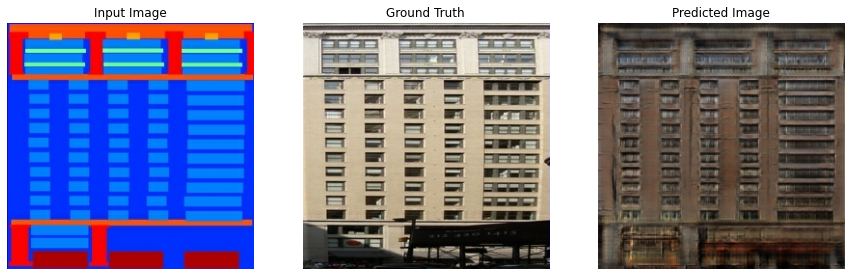

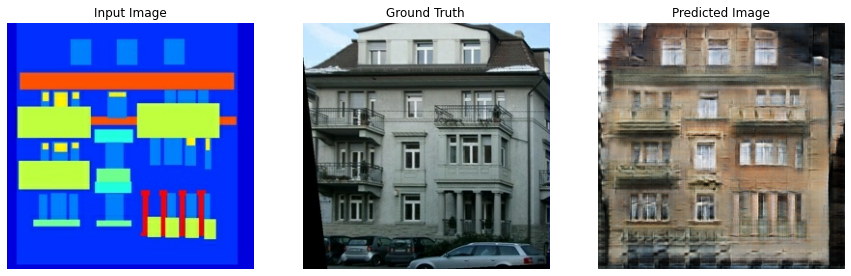

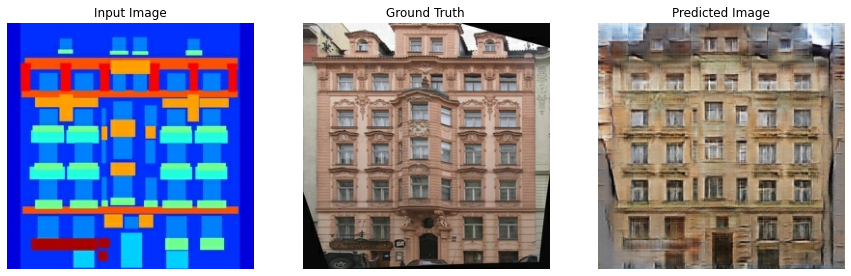

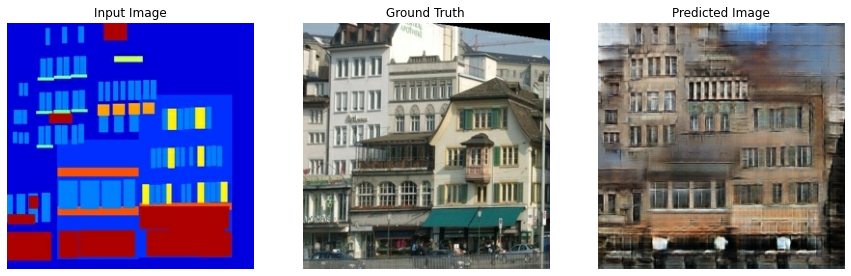

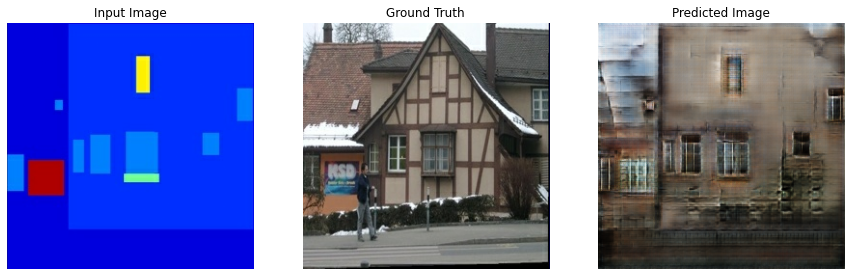

In [74]:
# Run the trained model on a few examples from the test set
for inp, tar in test_dataset.take(5):
  generate_images(generator, inp, tar)

## Часть вторая: добавим циклы
Вторая часть -- реализация CycleGAN. Предлагается на том же датасете реализовать базовую конструкцию CycleGAN для unpaired style transfer, то есть переноса стилей, каждый из которых задан неразмеченным датасетом (подробнее см. лекцию и собственно Zhu et al., 2017):

В качестве опционального задания за немного дополнительных баллов здесь предлагаю найти дополнительные данные такого рода (фасады и их карты сегментации) и улучшить качество переноса стиля за счёт обучения на датасете побольше. Данные, скорее всего, будут unpaired, поэтому эта часть скорее релевантна CycleGAN.


Для второй части задания использовала датасет и ноутбук с каггла с unpaired данными https://www.kaggle.com/balraj98/facades-dataset

In [2]:
# path to pre-trained models
pretrained_model_path = "../input/cyclegan-facades-segmentation-translation-pytorch/saved_models"
# epoch to start training from
epoch_start = 0
# number of epochs of training
n_epochs = 60
# name of the dataset
dataset_path = "../input/facades-dataset"
# size of the batches"
batch_size = 4
# adam: learning rate
lr = 0.00012
# adam: decay of first order momentum of gradient
b1 = 0.5
# adam: decay of first order momentum of gradient
b2 = 0.999
# epoch from which to start lr decay
decay_epoch = 1
# number of cpu threads to use during batch generation
n_workers = 4
# size of image height
img_height = 256
# size of image width
img_width = 256
# number of image channels
channels = 3
# interval between saving generator outputs
sample_interval = 100
# interval between saving model checkpoints
checkpoint_interval = -1
# number of residual blocks in generator
n_residual_blocks = 9
# cycle loss weight
lambda_cyc = 10.0
# identity loss weight
lambda_id = 5.0
# Development / Debug Mode
debug_mode = False

# Create images and checkpoint directories
os.makedirs("images", exist_ok=True)


### Определим вспомигательные функции

In [3]:
def to_rgb(image):
    rgb_image = Image.new("RGB", image.size)
    rgb_image.paste(image)
    return rgb_image


class ReplayBuffer:
    def __init__(self, max_size=50):
        assert max_size > 0, "Empty buffer or trying to create a black hole. Be careful."
        self.max_size = max_size
        self.data = []

    def push_and_pop(self, data):
        to_return = []
        for element in data.data:
            element = torch.unsqueeze(element, 0)
            if len(self.data) < self.max_size:
                self.data.append(element)
                to_return.append(element)
            else:
                if random.uniform(0, 1) > 0.5:
                    i = random.randint(0, self.max_size - 1)
                    to_return.append(self.data[i].clone())
                    self.data[i] = element
                else:
                    to_return.append(element)
        return Variable(torch.cat(to_return))



### Определим загрузчики датасетов

In [4]:
class ImageDataset(Dataset):
    def __init__(self, root, transforms_=None, unaligned=False, mode="train"):
        self.transform = transforms.Compose(transforms_)
        self.unaligned = unaligned

        self.files_A = sorted(glob.glob(os.path.join(root, f"{mode}A") + "/*.*"))
        self.files_B = sorted(glob.glob(os.path.join(root, f"{mode}B") + "/*.*"))
        if debug_mode:
            self.files_A = self.files_A[:100]
            self.files_B = self.files_B[:100]

    def __getitem__(self, index):
        image_A = Image.open(self.files_A[index % len(self.files_A)])

        if self.unaligned:
            image_B = Image.open(self.files_B[random.randint(0, len(self.files_B) - 1)])
        else:
            image_B = Image.open(self.files_B[index % len(self.files_B)])

#         # Convert grayscale images to rgb
#         if image_A.mode != "RGB":
#             image_A = to_rgb(image_A)
#         if image_B.mode != "RGB":
#             image_B = to_rgb(image_B)

        if np.random.random() < 0.5:
            image_A = Image.fromarray(np.array(image_A)[:, ::-1, :], "RGB")
            image_B = Image.fromarray(np.array(image_B)[:, ::-1, :], "RGB")
            
        item_A = self.transform(image_A)
        item_B = self.transform(image_B)
        return {"A": item_A, "B": item_B}

    def __len__(self):
        return max(len(self.files_A), len(self.files_B))

In [5]:
# Image transformations
transforms_ = [
    transforms.Resize(int(img_height * 1.12), Image.BICUBIC),
    transforms.RandomCrop((img_height, img_width)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
]

# Training data loader
train_dataloader = DataLoader(
    ImageDataset(f"{dataset_path}", transforms_=transforms_, unaligned=False),
    batch_size=batch_size,
    shuffle=True,
    num_workers=n_workers,
)
# Test data loader
test_dataloader = DataLoader(
    ImageDataset(f"{dataset_path}", transforms_=transforms_, unaligned=False, mode="test"),
    batch_size=1,
    shuffle=True,
    num_workers=1,
)

### Определим классы моделей

In [7]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
        if hasattr(m, "bias") and m.bias is not None:
            torch.nn.init.constant_(m.bias.data, 0.0)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)


class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()

        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features),
        )

    def forward(self, x):
        return x + self.block(x)


class GeneratorResNet(nn.Module):
    def __init__(self, input_shape, num_residual_blocks):
        super(GeneratorResNet, self).__init__()

        channels = input_shape[0]

        # Initial convolution block
        out_features = 64
        model = [
            nn.ReflectionPad2d(channels),
            nn.Conv2d(channels, out_features, 7),
            nn.InstanceNorm2d(out_features),
            nn.ReLU(inplace=True),
        ]
        in_features = out_features

        # Downsampling
        for _ in range(2):
            out_features *= 2
            model += [
                nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True),
            ]
            in_features = out_features

        # Residual blocks
        for _ in range(num_residual_blocks):
            model += [ResidualBlock(out_features)]

        # Upsampling
        for _ in range(2):
            out_features //= 2
            model += [
                nn.Upsample(scale_factor=2),
                nn.Conv2d(in_features, out_features, 3, stride=1, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True),
            ]
            in_features = out_features

        # Output layer
        model += [nn.ReflectionPad2d(channels), nn.Conv2d(out_features, channels, 7), nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)


class Discriminator(nn.Module):
    def __init__(self, input_shape):
        super(Discriminator, self).__init__()

        channels, height, width = input_shape

        # Calculate output shape of image discriminator (PatchGAN)
        self.output_shape = (1, height // 2 ** 4, width // 2 ** 4)

        def discriminator_block(in_filters, out_filters, normalize=True):
            """Returns downsampling layers of each discriminator block"""
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(channels, 64, normalize=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(512, 1, 4, padding=1)
        )

    def forward(self, img):
        return self.model(img)

## Обучение

In [8]:
# Losses
criterion_GAN = torch.nn.MSELoss()
criterion_cycle = torch.nn.L1Loss()
criterion_identity = torch.nn.L1Loss()

cuda = torch.cuda.is_available()

input_shape = (channels, img_height, img_width)

# Initialize generator and discriminator
G_AB = GeneratorResNet(input_shape, n_residual_blocks)
G_BA = GeneratorResNet(input_shape, n_residual_blocks)
D_A = Discriminator(input_shape)
D_B = Discriminator(input_shape)

if cuda:
    G_AB = G_AB.cuda()
    G_BA = G_BA.cuda()
    D_A = D_A.cuda()
    D_B = D_B.cuda()
    criterion_GAN.cuda()
    criterion_cycle.cuda()
    criterion_identity.cuda()

if epoch_start != 0:
    # Load pretrained models
    G_AB.load_state_dict(torch.load(f"{pretrained_model_path}/G_AB.pth"))
    G_BA.load_state_dict(torch.load(f"{pretrained_model_path}/G_BA.pth"))
    D_A.load_state_dict(torch.load(f"{pretrained_model_path}/D_A.pth"))
    D_B.load_state_dict(torch.load(f"{pretrained_model_path}/D_B.pth"))
else:
    # Initialize weights
    G_AB.apply(weights_init_normal)
    G_BA.apply(weights_init_normal)
    D_A.apply(weights_init_normal)
    D_B.apply(weights_init_normal)

# Optimizers
optimizer_G = torch.optim.Adam(
    itertools.chain(G_AB.parameters(), G_BA.parameters()), lr=lr, betas=(b1, b2)
)
optimizer_D_A = torch.optim.Adam(D_A.parameters(), lr=lr, betas=(b1, b2))
optimizer_D_B = torch.optim.Adam(D_B.parameters(), lr=lr, betas=(b1, b2))

Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor

# Buffers of previously generated samples
fake_A_buffer = ReplayBuffer()
fake_B_buffer = ReplayBuffer()

train_counter = []
train_losses_gen, train_losses_id, train_losses_gan, train_losses_cyc = [], [], [], []
train_losses_disc, train_losses_disc_a, train_losses_disc_b = [], [], []

test_counter = [2*idx*len(train_dataloader.dataset) for idx in range(epoch_start+1, n_epochs+1)]
test_losses_gen, test_losses_disc = [], []



In [9]:
for epoch in range(epoch_start, n_epochs):
    
    #### Training
    loss_gen = loss_id = loss_gan = loss_cyc = 0.0
    loss_disc = loss_disc_a = loss_disc_b = 0.0
    tqdm_bar = tqdm(train_dataloader, desc=f'Training Epoch {epoch} ', total=int(len(train_dataloader)))
    for batch_idx, batch in enumerate(tqdm_bar):

        # Set model input
        real_A = Variable(batch["A"].type(Tensor))
        real_B = Variable(batch["B"].type(Tensor))
        # Adversarial ground truths
        valid = Variable(Tensor(np.ones((real_A.size(0), *D_A.output_shape))), requires_grad=False)
        fake = Variable(Tensor(np.zeros((real_A.size(0), *D_A.output_shape))), requires_grad=False)

        ### Train Generators
        G_AB.train()
        G_BA.train()
        optimizer_G.zero_grad()
        # Identity loss
        loss_id_A = criterion_identity(G_BA(real_A), real_A)
        loss_id_B = criterion_identity(G_AB(real_B), real_B)
        loss_identity = (loss_id_A + loss_id_B) / 2
        # GAN loss
        fake_B = G_AB(real_A)
        loss_GAN_AB = criterion_GAN(D_B(fake_B), valid)
        fake_A = G_BA(real_B)
        loss_GAN_BA = criterion_GAN(D_A(fake_A), valid)
        loss_GAN = (loss_GAN_AB + loss_GAN_BA) / 2
        # Cycle loss
        recov_A = G_BA(fake_B)
        loss_cycle_A = criterion_cycle(recov_A, real_A)
        recov_B = G_AB(fake_A)
        loss_cycle_B = criterion_cycle(recov_B, real_B)
        loss_cycle = (loss_cycle_A + loss_cycle_B) / 2
        # Total loss
        loss_G = lambda_id * loss_identity + loss_GAN + lambda_cyc * loss_cycle
        loss_G.backward()
        optimizer_G.step()

        ### Train Discriminator-A
        D_A.train()
        optimizer_D_A.zero_grad()
        # Real loss
        loss_real = criterion_GAN(D_A(real_A), valid)
        # Fake loss (on batch of previously generated samples)
        fake_A_ = fake_A_buffer.push_and_pop(fake_A)
        loss_fake = criterion_GAN(D_A(fake_A_.detach()), fake)
        # Total loss
        loss_D_A = (loss_real + loss_fake) / 2
        loss_D_A.backward()
        optimizer_D_A.step()

        ### Train Discriminator-B
        D_B.train()
        optimizer_D_B.zero_grad()
        # Real loss
        loss_real = criterion_GAN(D_B(real_B), valid)
        # Fake loss (on batch of previously generated samples)
        fake_B_ = fake_B_buffer.push_and_pop(fake_B)
        loss_fake = criterion_GAN(D_B(fake_B_.detach()), fake)
        # Total loss
        loss_D_B = (loss_real + loss_fake) / 2
        loss_D_B.backward()
        optimizer_D_B.step()
        loss_D = (loss_D_A + loss_D_B) / 2

        ### Log Progress
        loss_gen += loss_G.item(); loss_id += loss_identity.item(); loss_gan += loss_GAN.item(); loss_cyc += loss_cycle.item()
        loss_disc += loss_D.item(); loss_disc_a += loss_D_A.item(); loss_disc_b += loss_D_B.item()
        train_counter.append(2*(batch_idx*batch_size + real_A.size(0) + epoch*len(train_dataloader.dataset)))
        train_losses_gen.append(loss_G.item()); train_losses_id.append(loss_identity.item()); train_losses_gan.append(loss_GAN.item()); train_losses_cyc.append(loss_cycle.item())
        train_losses_disc.append(loss_D.item()); train_losses_disc_a.append(loss_D_A.item()); train_losses_disc_b.append(loss_D_B.item())
        tqdm_bar.set_postfix(Gen_loss=loss_gen/(batch_idx+1), identity=loss_id/(batch_idx+1), adv=loss_gan/(batch_idx+1), cycle=loss_cyc/(batch_idx+1),
                            Disc_loss=loss_disc/(batch_idx+1), disc_a=loss_disc_a/(batch_idx+1), disc_b=loss_disc_b/(batch_idx+1))

    #### Testing
    loss_gen = loss_id = loss_gan = loss_cyc = 0.0
    loss_disc = loss_disc_a = loss_disc_b = 0.0
    tqdm_bar = tqdm(test_dataloader, desc=f'Testing Epoch {epoch} ', total=int(len(test_dataloader)))
    for batch_idx, batch in enumerate(tqdm_bar):

        # Set model input
        real_A = Variable(batch["A"].type(Tensor))
        real_B = Variable(batch["B"].type(Tensor))
        # Adversarial ground truths
        valid = Variable(Tensor(np.ones((real_A.size(0), *D_A.output_shape))), requires_grad=False)
        fake = Variable(Tensor(np.zeros((real_A.size(0), *D_A.output_shape))), requires_grad=False)

        ### Test Generators
        G_AB.eval()
        G_BA.eval()
        # Identity loss
        loss_id_A = criterion_identity(G_BA(real_A), real_A)
        loss_id_B = criterion_identity(G_AB(real_B), real_B)
        loss_identity = (loss_id_A + loss_id_B) / 2
        # GAN loss
        fake_B = G_AB(real_A)
        loss_GAN_AB = criterion_GAN(D_B(fake_B), valid)
        fake_A = G_BA(real_B)
        loss_GAN_BA = criterion_GAN(D_A(fake_A), valid)
        loss_GAN = (loss_GAN_AB + loss_GAN_BA) / 2
        # Cycle loss
        recov_A = G_BA(fake_B)
        loss_cycle_A = criterion_cycle(recov_A, real_A)
        recov_B = G_AB(fake_A)
        loss_cycle_B = criterion_cycle(recov_B, real_B)
        loss_cycle = (loss_cycle_A + loss_cycle_B) / 2
        # Total loss
        loss_G = loss_GAN + lambda_cyc * loss_cycle + lambda_id * loss_identity

        ### Test Discriminator-A
        D_A.eval()
        # Real loss
        loss_real = criterion_GAN(D_A(real_A), valid)
        # Fake loss (on batch of previously generated samples)
        fake_A_ = fake_A_buffer.push_and_pop(fake_A)
        loss_fake = criterion_GAN(D_A(fake_A_.detach()), fake)
        # Total loss
        loss_D_A = (loss_real + loss_fake) / 2

        ### Test Discriminator-B
        D_B.eval()
        # Real loss
        loss_real = criterion_GAN(D_B(real_B), valid)
        # Fake loss (on batch of previously generated samples)
        fake_B_ = fake_B_buffer.push_and_pop(fake_B)
        loss_fake = criterion_GAN(D_B(fake_B_.detach()), fake)
        # Total loss
        loss_D_B = (loss_real + loss_fake) / 2
        loss_D = (loss_D_A + loss_D_B) / 2
        
        ### Log Progress
        loss_gen += loss_G.item(); loss_id += loss_identity.item(); loss_gan += loss_GAN.item(); loss_cyc += loss_cycle.item()
        loss_disc += loss_D.item(); loss_disc_a += loss_D_A.item(); loss_disc_b += loss_D_B.item()
        tqdm_bar.set_postfix(Gen_loss=loss_gen/(batch_idx+1), identity=loss_id/(batch_idx+1), adv=loss_gan/(batch_idx+1), cycle=loss_cyc/(batch_idx+1),
                            Disc_loss=loss_disc/(batch_idx+1), disc_a=loss_disc_a/(batch_idx+1), disc_b=loss_disc_b/(batch_idx+1))
        
        # If at sample interval save image
        if random.uniform(0,1)<0.4:
            # Arrange images along x-axis
            real_A = make_grid(real_A, nrow=1, normalize=True)
            real_B = make_grid(real_B, nrow=1, normalize=True)
            fake_A = make_grid(fake_A, nrow=1, normalize=True)
            fake_B = make_grid(fake_B, nrow=1, normalize=True)
            # Arange images along y-axis
            image_grid = torch.cat((real_B, fake_A, real_A), -1)
            save_image(image_grid, f"images/{batch_idx}.png", normalize=False)

    test_losses_gen.append(loss_gen/len(test_dataloader))
    test_losses_disc.append(loss_disc/len(test_dataloader))

    # Save model checkpoints
    if np.argmin(test_losses_gen) == len(test_losses_gen)-1:
        # Save model checkpoints
        torch.save(G_AB.state_dict(), "G_AB.pth")
        torch.save(G_BA.state_dict(), "G_BA.pth")
        torch.save(D_A.state_dict(), "D_A.pth")
        torch.save(D_B.state_dict(), "D_B.pth")

Training Epoch 0 :   0%|          | 0/100 [00:00<?, ?it/s]

Testing Epoch 0 :   0%|          | 0/106 [00:00<?, ?it/s]

Training Epoch 1 :   0%|          | 0/100 [00:00<?, ?it/s]

Testing Epoch 1 :   0%|          | 0/106 [00:00<?, ?it/s]

Training Epoch 2 :   0%|          | 0/100 [00:00<?, ?it/s]

Testing Epoch 2 :   0%|          | 0/106 [00:00<?, ?it/s]

Training Epoch 3 :   0%|          | 0/100 [00:00<?, ?it/s]

Testing Epoch 3 :   0%|          | 0/106 [00:00<?, ?it/s]

Training Epoch 4 :   0%|          | 0/100 [00:00<?, ?it/s]

Testing Epoch 4 :   0%|          | 0/106 [00:00<?, ?it/s]

Training Epoch 5 :   0%|          | 0/100 [00:00<?, ?it/s]

Testing Epoch 5 :   0%|          | 0/106 [00:00<?, ?it/s]

Training Epoch 6 :   0%|          | 0/100 [00:00<?, ?it/s]

Testing Epoch 6 :   0%|          | 0/106 [00:00<?, ?it/s]

Training Epoch 7 :   0%|          | 0/100 [00:00<?, ?it/s]

Testing Epoch 7 :   0%|          | 0/106 [00:00<?, ?it/s]

Training Epoch 8 :   0%|          | 0/100 [00:00<?, ?it/s]

Testing Epoch 8 :   0%|          | 0/106 [00:00<?, ?it/s]

Training Epoch 9 :   0%|          | 0/100 [00:00<?, ?it/s]

Testing Epoch 9 :   0%|          | 0/106 [00:00<?, ?it/s]

Training Epoch 10 :   0%|          | 0/100 [00:00<?, ?it/s]

Testing Epoch 10 :   0%|          | 0/106 [00:00<?, ?it/s]

Training Epoch 11 :   0%|          | 0/100 [00:00<?, ?it/s]

Testing Epoch 11 :   0%|          | 0/106 [00:00<?, ?it/s]

Training Epoch 12 :   0%|          | 0/100 [00:00<?, ?it/s]

Testing Epoch 12 :   0%|          | 0/106 [00:00<?, ?it/s]

Training Epoch 13 :   0%|          | 0/100 [00:00<?, ?it/s]

Testing Epoch 13 :   0%|          | 0/106 [00:00<?, ?it/s]

Training Epoch 14 :   0%|          | 0/100 [00:00<?, ?it/s]

Testing Epoch 14 :   0%|          | 0/106 [00:00<?, ?it/s]

Training Epoch 15 :   0%|          | 0/100 [00:00<?, ?it/s]

Testing Epoch 15 :   0%|          | 0/106 [00:00<?, ?it/s]

Training Epoch 16 :   0%|          | 0/100 [00:00<?, ?it/s]

Testing Epoch 16 :   0%|          | 0/106 [00:00<?, ?it/s]

Training Epoch 17 :   0%|          | 0/100 [00:00<?, ?it/s]

Testing Epoch 17 :   0%|          | 0/106 [00:00<?, ?it/s]

Training Epoch 18 :   0%|          | 0/100 [00:00<?, ?it/s]

Testing Epoch 18 :   0%|          | 0/106 [00:00<?, ?it/s]

Training Epoch 19 :   0%|          | 0/100 [00:00<?, ?it/s]

Testing Epoch 19 :   0%|          | 0/106 [00:00<?, ?it/s]

Training Epoch 20 :   0%|          | 0/100 [00:00<?, ?it/s]

Testing Epoch 20 :   0%|          | 0/106 [00:00<?, ?it/s]

Training Epoch 21 :   0%|          | 0/100 [00:00<?, ?it/s]

Testing Epoch 21 :   0%|          | 0/106 [00:00<?, ?it/s]

Training Epoch 22 :   0%|          | 0/100 [00:00<?, ?it/s]

Testing Epoch 22 :   0%|          | 0/106 [00:00<?, ?it/s]

Training Epoch 23 :   0%|          | 0/100 [00:00<?, ?it/s]

Testing Epoch 23 :   0%|          | 0/106 [00:00<?, ?it/s]

Training Epoch 24 :   0%|          | 0/100 [00:00<?, ?it/s]

Testing Epoch 24 :   0%|          | 0/106 [00:00<?, ?it/s]

Training Epoch 25 :   0%|          | 0/100 [00:00<?, ?it/s]

Testing Epoch 25 :   0%|          | 0/106 [00:00<?, ?it/s]

Training Epoch 26 :   0%|          | 0/100 [00:00<?, ?it/s]

Testing Epoch 26 :   0%|          | 0/106 [00:00<?, ?it/s]

Training Epoch 27 :   0%|          | 0/100 [00:00<?, ?it/s]

Testing Epoch 27 :   0%|          | 0/106 [00:00<?, ?it/s]

Training Epoch 28 :   0%|          | 0/100 [00:00<?, ?it/s]

Testing Epoch 28 :   0%|          | 0/106 [00:00<?, ?it/s]

Training Epoch 29 :   0%|          | 0/100 [00:00<?, ?it/s]

Testing Epoch 29 :   0%|          | 0/106 [00:00<?, ?it/s]

Training Epoch 30 :   0%|          | 0/100 [00:00<?, ?it/s]

Testing Epoch 30 :   0%|          | 0/106 [00:00<?, ?it/s]

Training Epoch 31 :   0%|          | 0/100 [00:00<?, ?it/s]

Testing Epoch 31 :   0%|          | 0/106 [00:00<?, ?it/s]

Training Epoch 32 :   0%|          | 0/100 [00:00<?, ?it/s]

Testing Epoch 32 :   0%|          | 0/106 [00:00<?, ?it/s]

Training Epoch 33 :   0%|          | 0/100 [00:00<?, ?it/s]

Testing Epoch 33 :   0%|          | 0/106 [00:00<?, ?it/s]

Training Epoch 34 :   0%|          | 0/100 [00:00<?, ?it/s]

Testing Epoch 34 :   0%|          | 0/106 [00:00<?, ?it/s]

Training Epoch 35 :   0%|          | 0/100 [00:00<?, ?it/s]

Testing Epoch 35 :   0%|          | 0/106 [00:00<?, ?it/s]

Training Epoch 36 :   0%|          | 0/100 [00:00<?, ?it/s]

Testing Epoch 36 :   0%|          | 0/106 [00:00<?, ?it/s]

Training Epoch 37 :   0%|          | 0/100 [00:00<?, ?it/s]

Testing Epoch 37 :   0%|          | 0/106 [00:00<?, ?it/s]

Training Epoch 38 :   0%|          | 0/100 [00:00<?, ?it/s]

Testing Epoch 38 :   0%|          | 0/106 [00:00<?, ?it/s]

Training Epoch 39 :   0%|          | 0/100 [00:00<?, ?it/s]

Testing Epoch 39 :   0%|          | 0/106 [00:00<?, ?it/s]

Training Epoch 40 :   0%|          | 0/100 [00:00<?, ?it/s]

Testing Epoch 40 :   0%|          | 0/106 [00:00<?, ?it/s]

Training Epoch 41 :   0%|          | 0/100 [00:00<?, ?it/s]

Testing Epoch 41 :   0%|          | 0/106 [00:00<?, ?it/s]

Training Epoch 42 :   0%|          | 0/100 [00:00<?, ?it/s]

Testing Epoch 42 :   0%|          | 0/106 [00:00<?, ?it/s]

Training Epoch 43 :   0%|          | 0/100 [00:00<?, ?it/s]

Testing Epoch 43 :   0%|          | 0/106 [00:00<?, ?it/s]

Training Epoch 44 :   0%|          | 0/100 [00:00<?, ?it/s]

Testing Epoch 44 :   0%|          | 0/106 [00:00<?, ?it/s]

Training Epoch 45 :   0%|          | 0/100 [00:00<?, ?it/s]

Testing Epoch 45 :   0%|          | 0/106 [00:00<?, ?it/s]

Training Epoch 46 :   0%|          | 0/100 [00:00<?, ?it/s]

Testing Epoch 46 :   0%|          | 0/106 [00:00<?, ?it/s]

Training Epoch 47 :   0%|          | 0/100 [00:00<?, ?it/s]

Testing Epoch 47 :   0%|          | 0/106 [00:00<?, ?it/s]

Training Epoch 48 :   0%|          | 0/100 [00:00<?, ?it/s]

Testing Epoch 48 :   0%|          | 0/106 [00:00<?, ?it/s]

Training Epoch 49 :   0%|          | 0/100 [00:00<?, ?it/s]

Testing Epoch 49 :   0%|          | 0/106 [00:00<?, ?it/s]

Training Epoch 50 :   0%|          | 0/100 [00:00<?, ?it/s]

Testing Epoch 50 :   0%|          | 0/106 [00:00<?, ?it/s]

Training Epoch 51 :   0%|          | 0/100 [00:00<?, ?it/s]

Testing Epoch 51 :   0%|          | 0/106 [00:00<?, ?it/s]

Training Epoch 52 :   0%|          | 0/100 [00:00<?, ?it/s]

Testing Epoch 52 :   0%|          | 0/106 [00:00<?, ?it/s]

Training Epoch 53 :   0%|          | 0/100 [00:00<?, ?it/s]

Testing Epoch 53 :   0%|          | 0/106 [00:00<?, ?it/s]

Training Epoch 54 :   0%|          | 0/100 [00:00<?, ?it/s]

Testing Epoch 54 :   0%|          | 0/106 [00:00<?, ?it/s]

Training Epoch 55 :   0%|          | 0/100 [00:00<?, ?it/s]

Testing Epoch 55 :   0%|          | 0/106 [00:00<?, ?it/s]

Training Epoch 56 :   0%|          | 0/100 [00:00<?, ?it/s]

Testing Epoch 56 :   0%|          | 0/106 [00:00<?, ?it/s]

Training Epoch 57 :   0%|          | 0/100 [00:00<?, ?it/s]

Testing Epoch 57 :   0%|          | 0/106 [00:00<?, ?it/s]

Training Epoch 58 :   0%|          | 0/100 [00:00<?, ?it/s]

Testing Epoch 58 :   0%|          | 0/106 [00:00<?, ?it/s]

Training Epoch 59 :   0%|          | 0/100 [00:00<?, ?it/s]

Testing Epoch 59 :   0%|          | 0/106 [00:00<?, ?it/s]

смотрим результат:

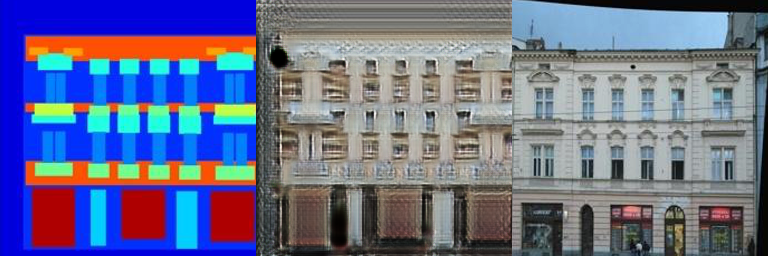

In [17]:
from IPython.display import Image
Image(filename='images/1.png') 

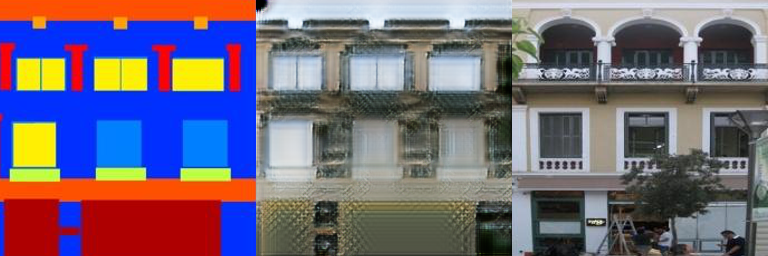

In [21]:
Image(filename='images/45.png') 

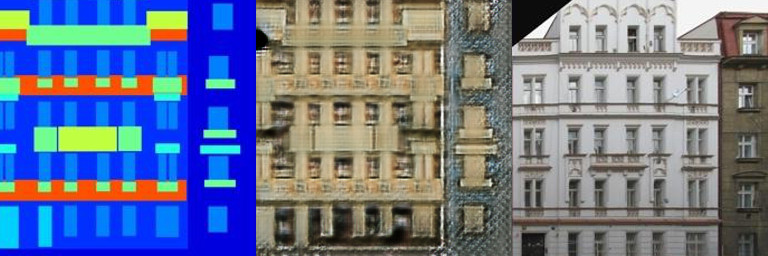

In [24]:
Image(filename='images/50.png') 